# 5.2 PyTorch的nn模块

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(2020)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 2,  7,  8,  9, 10,  0,  1,  4,  6]), tensor([3, 5]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
linear_model = nn.Linear(1, 1) # 参数: input size, output size, bias(默认True)
linear_model(t_un_val)

tensor([[1.2665],
        [1.0006]], grad_fn=<AddmmBackward>)

In [6]:
linear_model.forward(t_un_val) # 虽然输出结果是一样的但不应该这样做!!

tensor([[1.2665],
        [1.0006]], grad_fn=<AddmmBackward>)

In [7]:
linear_model.weight

Parameter containing:
tensor([[0.0806]], requires_grad=True)

In [8]:
linear_model.bias

Parameter containing:
tensor([0.6065], requires_grad=True)

In [9]:
x = torch.ones(1)
linear_model(x)

tensor([0.6871], grad_fn=<AddBackward0>)

In [10]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.6871],
        [0.6871],
        [0.6871],
        [0.6871],
        [0.6871],
        [0.6871],
        [0.6871],
        [0.6871],
        [0.6871],
        [0.6871]], grad_fn=<AddmmBackward>)

In [11]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2)

In [12]:
linear_model.parameters()

<generator object Module.parameters at 0x11abacf10>

In [13]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.5563]], requires_grad=True), Parameter containing:
 tensor([-0.0067], requires_grad=True)]

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, 
                  t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_un_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_un_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch %d, Training loss %.4f, Validation loss %.4f' % (
                    epoch, float(loss_train), float(loss_val)))

In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # 不再使用自己定义的loss
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 66.0145, Validation loss 239.8421
Epoch 1000, Training loss 4.1785, Validation loss 9.3629
Epoch 2000, Training loss 3.2060, Validation loss 3.8825
Epoch 3000, Training loss 3.1601, Validation loss 3.0151

Parameter containing:
tensor([[5.0940]], requires_grad=True)
Parameter containing:
tensor([-16.0012], requires_grad=True)


In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.1786], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # 为了稳定性调小了梯度

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 142.5878, Validation loss 439.7242
Epoch 1000, Training loss 4.9129, Validation loss 46.7108
Epoch 2000, Training loss 3.4471, Validation loss 25.7202
Epoch 3000, Training loss 2.8642, Validation loss 16.3709
Epoch 4000, Training loss 2.5688, Validation loss 11.2405
Epoch 5000, Training loss 2.3860, Validation loss 8.0017
output tensor([[24.0087],
        [ 7.7348]], grad_fn=<AddmmBackward>)
answer tensor([[28.],
        [ 8.]])
hidden tensor([[ 0.0207],
        [ 0.0272],
        [-0.0065],
        [ 0.1072],
        [ 0.0060],
        [ 0.0142],
        [ 0.0004],
        [-0.0004]])


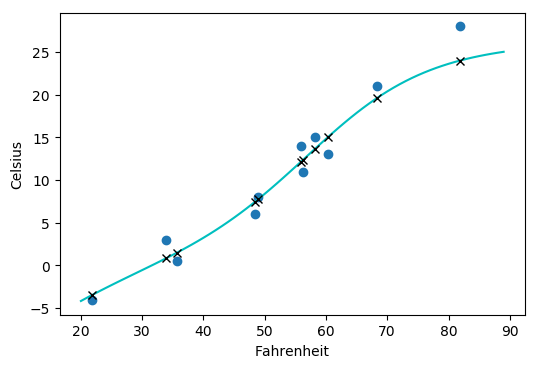

In [23]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
plt.show()